'1.6.0'

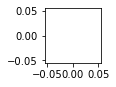

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# force plt on windows 10
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.plot()

import sys
sys.path.append("..")

import torch
import torch.nn as nn
import numpy as np
import aggets.ds.window as window
import aggets.ds.hyper_f_load as hfl
import aggets.ds.window as window
import aggets.train as train
import aggets.ds.load as load

## DISABLE THIS
import warnings
warnings.filterwarnings("ignore")
torch.__version__

In [2]:
agrg = load.load('../../streaming-datasets/agr_g.csv', normalize = 1)

In [3]:
import aggets.ds.aggregate_nd as agg_nd
cols = ['salary', 'commission', 'age', 'elevel', 'car', 'zipcode', 'hvalue', 'hyears', 'loan']
train_np = agg_nd.as_np(agrg['train'], cols, 'class')
val_np = agg_nd.as_np(agrg['val'], cols, 'class')
test_np = agg_nd.as_np(agrg['test'], cols, 'class')

window = agg_nd.window_generator(train_np, val_np, test_np, window_size=500, e=0.00001, hist_bins=20, hist_dim=1)

ranges -> [[-9.9999997e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000099e+00]
 [-9.9999997e-06  1.0000099e+00]
 [-9.9999997e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000100e+00]]


In [4]:
window.init_structures()
import aggets.util as util
# util.save(window, path='agrg_window_01.bin') # window_size=50, e=0.00001, hist_bins=5, hist_dim=2
util.save(window, path='agrg_window_03.bin') # window_size=50, e=0.00001, hist_bins=5, hist_dim=2
# w = util.load(path='agrg_window_01.bin') # 5 bins, 2 dim, 500ws
# w = util.load(path='agrg_window_02.bin') # 20 bins, 1 dim, 50ws, train_split=0.2, val_split=0.5
w = util.load(path='agrg_window_03.bin') # 20 bins, 1 dim, 500ws

In [5]:
w = window

In [9]:
print('aggregates')
print(w.train_agges.shape)
print(w.val_agges.shape)
print(w.test_agges.shape)
print('models')
print(w.train_models.shape)
print(w.val_models.shape)
print(w.test_models.shape)
print('')
from aggets.model.aggregate import WindowConfig
dl = w.wrapped(WindowConfig(output_sequence_length=5, input_sequence_length=10),
              other={'source': 'agg', 'target': 'lr'}).train

print('sets')
def get_item_shape(item):
    if type(item) == list:
       return (item[0].shape, item[1].shape)
    return item.shape
[get_item_shape(l) for l in next(iter(dl))]


aggregates
torch.Size([1400, 5, 2, 9, 20])
torch.Size([400, 5, 2, 9, 20])
torch.Size([200, 5, 2, 9, 20])
models
torch.Size([1400, 5, 10])
torch.Size([400, 5, 10])
torch.Size([200, 5, 10])

sets


[torch.Size([32, 10, 2, 9, 20]), torch.Size([32, 5, 10])]

training model autoreg-lstm
saving model MTL=0.03133989104031143, MVL=0.0266209180604239
saving model MTL=0.025531577092299265, MVL=0.026031158162189313


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

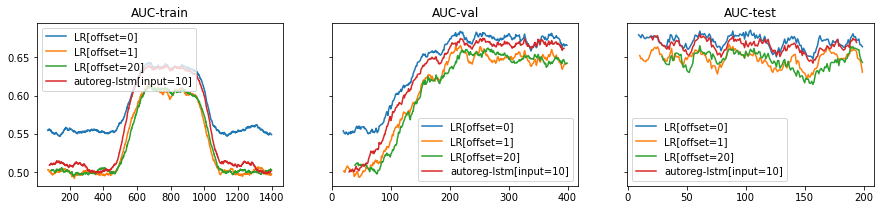

In [7]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST -> LR
hidden = 256

flatten = agg_m.Flatten(out_seq=5)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=360, num_layers=1, out_features=hidden)
)
out = simple.mlp(features=hidden, num_layers=1, out_features=10)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=5, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='agg', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'agg', 'target':'lr'})

training model fourier
saving model MTL=0.02654899552532839, MVL=0.028006353675097715


<Figure size 432x288 with 0 Axes>

saving model MTL=0.025113602194490783, MVL=0.02590227701136323


<Figure size 432x288 with 0 Axes>

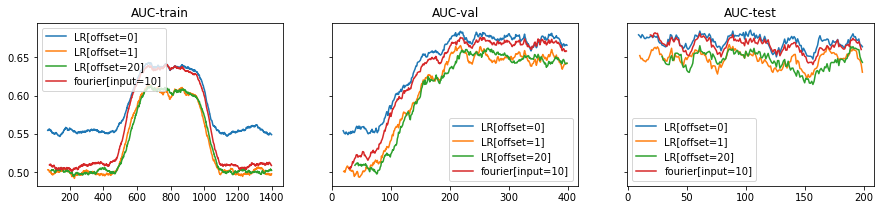

In [10]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
import aggets.model.fourier as fourier
# LR -> LR
size = 10

frr = fourier.HistogramLerner(extra_dims=0, t_in=10)
frr = fourier.FAdapter3(frr)
frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# -------
frr.name = 'fourier'
train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
                          lrs=[0.001, 0.0001],
                          source='lr', target='lr', log=False)

# ------- lr
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(frr, axs=axs, other={'source':'lr', 'target':'lr'})

In [ ]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST+LR -> LR
hidden = 256

inp = nn.Sequential(
    agg_m.FlatCat(),
    simple.mlp(features=370, num_layers=1, out_features=hidden)
)
out = simple.mlp(features=hidden, num_layers=2, out_features=10)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='all', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'all', 'target':'lr'})

training model fourier
d-2-shape torch.Size([1, 1, 2, 1, 1])
d-3-shape torch.Size([1, 1, 1, 9, 1])
saving model MTL=0.4333828437882356, MVL=0.44272355703461885
saving model MTL=0.4353220407397319, MVL=0.44103321897932607


<Figure size 432x288 with 0 Axes>

saving model MTL=0.4064018639425437, MVL=0.44089922554090494


<Figure size 432x288 with 0 Axes>

ValueError: X has 9 features per sample; expecting 180

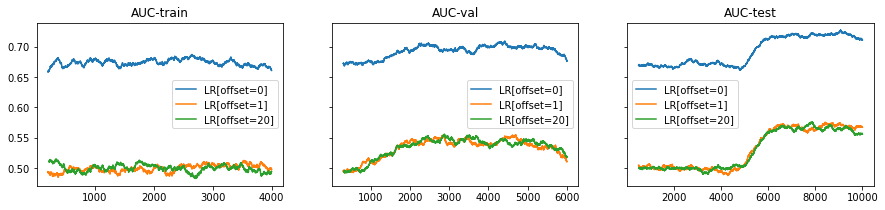

In [91]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
import aggets.model.fourier as fourier
# HIST -> HIST

frr = fourier.HistogramLerner(extra_dims=2, t_in=10)
frr = fourier.FAdapter3(frr)
frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# -------
frr.name = 'fourier'
train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
                          lrs=[0.001, 0.0001],
                          source='agg', target='agg', log=False)

# ------- hist
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(frr, axs=axs, other={'source':'agg', 'target':'agg'})

ValueError: X has 9 features per sample; expecting 180

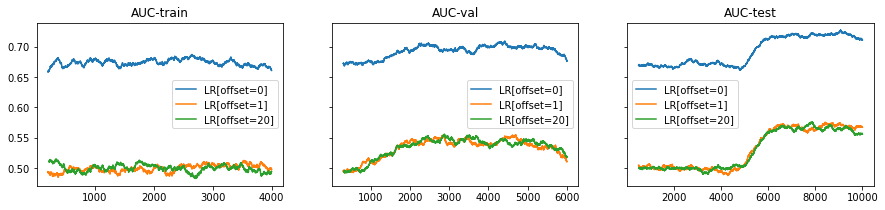

In [92]:
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(frr, axs=axs, other={'source':'agg', 'target':'agg'})